In [147]:
import numpy as np
import pandas
import hddm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import math
import re

# Simulate both drift and start point biases

from Leite & Ratcliff (2011) -- What cognitive processes drive response biases? A diffusion model analysis:

"In the diffusion model, there are two ways to model response bias (Ratcliff, 1985; Ratcliff et al., 1999; Ratcliff & McKoon, 2008). One, analogous to the change in criterion threshold in SDT, involves a shift in the criterion that separates positive from negative drift rates. That is, one parameter (referred to as a “drift criterion” parameter, “dc”) produces an estimate of the amount to be added to or subtracted from the mean drift rates between conditions such that a null mean drift rate (a horizontal line starting at z in Figure 1.1) in an unbiased condition would be shifted to a positive or negative mean drift rate in a biased condition, for example. For small to moderate biases in drift rates, there are only small changes in the leading edges of the RT distributions between biased and unbiased conditions. The other way to model response bias involves moving the starting point of the diffusion process nearer the boundary toward which the responses are biased (Figure 1.1). This predicts a shorter leading edge of the RT distribution in the biased condition than in the unbiased condition (Ratcliff, 1985, 2002)."

Can we replicate this?

In [148]:
v = 0.8
a = 2.0
t = 1
z = 0.5
sz = 0
st = 0
sv = 0

drift_biases = [-0.0, -0.1, -0.2, -0.3, -0.4]
startpoint_biases = [-0.0, -0.05, -0.10, -0.15, -0.20]

In [149]:
parameters = []
conditions = []
for drift_bias, start_point_bias in itertools.product(drift_biases, startpoint_biases):
    # print drift_bias, start_point_bias
    conditions.append('biased.drift.%s.z.%s' % (drift_bias, start_point_bias))
    parameters.append({'v':v+drift_bias, 'a':a, 't':t,'sv':sv, 'z':z+start_point_bias, 'sz': sz, 'st': st})
    conditions.append('anti-biased.drift.%s.z.%s' % (drift_bias, start_point_bias))
    parameters.append({'v':v-drift_bias, 'a':a, 't':t,'sv':sv, 'z':z-start_point_bias, 'sz': sz, 'st': st})

In [150]:
df, params = hddm.generate.gen_rand_data(dict(zip(conditions, parameters)), size=10000, subjs=1)

In [151]:
reg = re.compile('(?P<bias>[a-z_-]+).drift.(?P<drift_bias>.*).z.(?P<start_point_bias>.*)')
df['bias_direction'] = df['condition'].apply(lambda x: reg.match(x).group('bias'))
df['drift_bias'] = df['condition'].apply(lambda x: reg.match(x).group('drift_bias'))
df['start_point_bias'] = df['condition'].apply(lambda x: reg.match(x).group('start_point_bias'))

In [152]:
def get_choice(row):
    
    if row.bias_direction == 'biased':
        if row.response == 1:
            return 'biased_option'
        else:
            return 'anti-biased option'
    elif row.bias_direction == 'anti-biased':
        if row.response == 0:
            return 'biased_option'
        else:
            return 'anti-biased option' 
df['bias_response'] = df.apply(get_choice, 1)

Indeed, drift criterion only has a small effect on the leading edge of the RT distribution, while starting point has a large effect:

(0, 3)

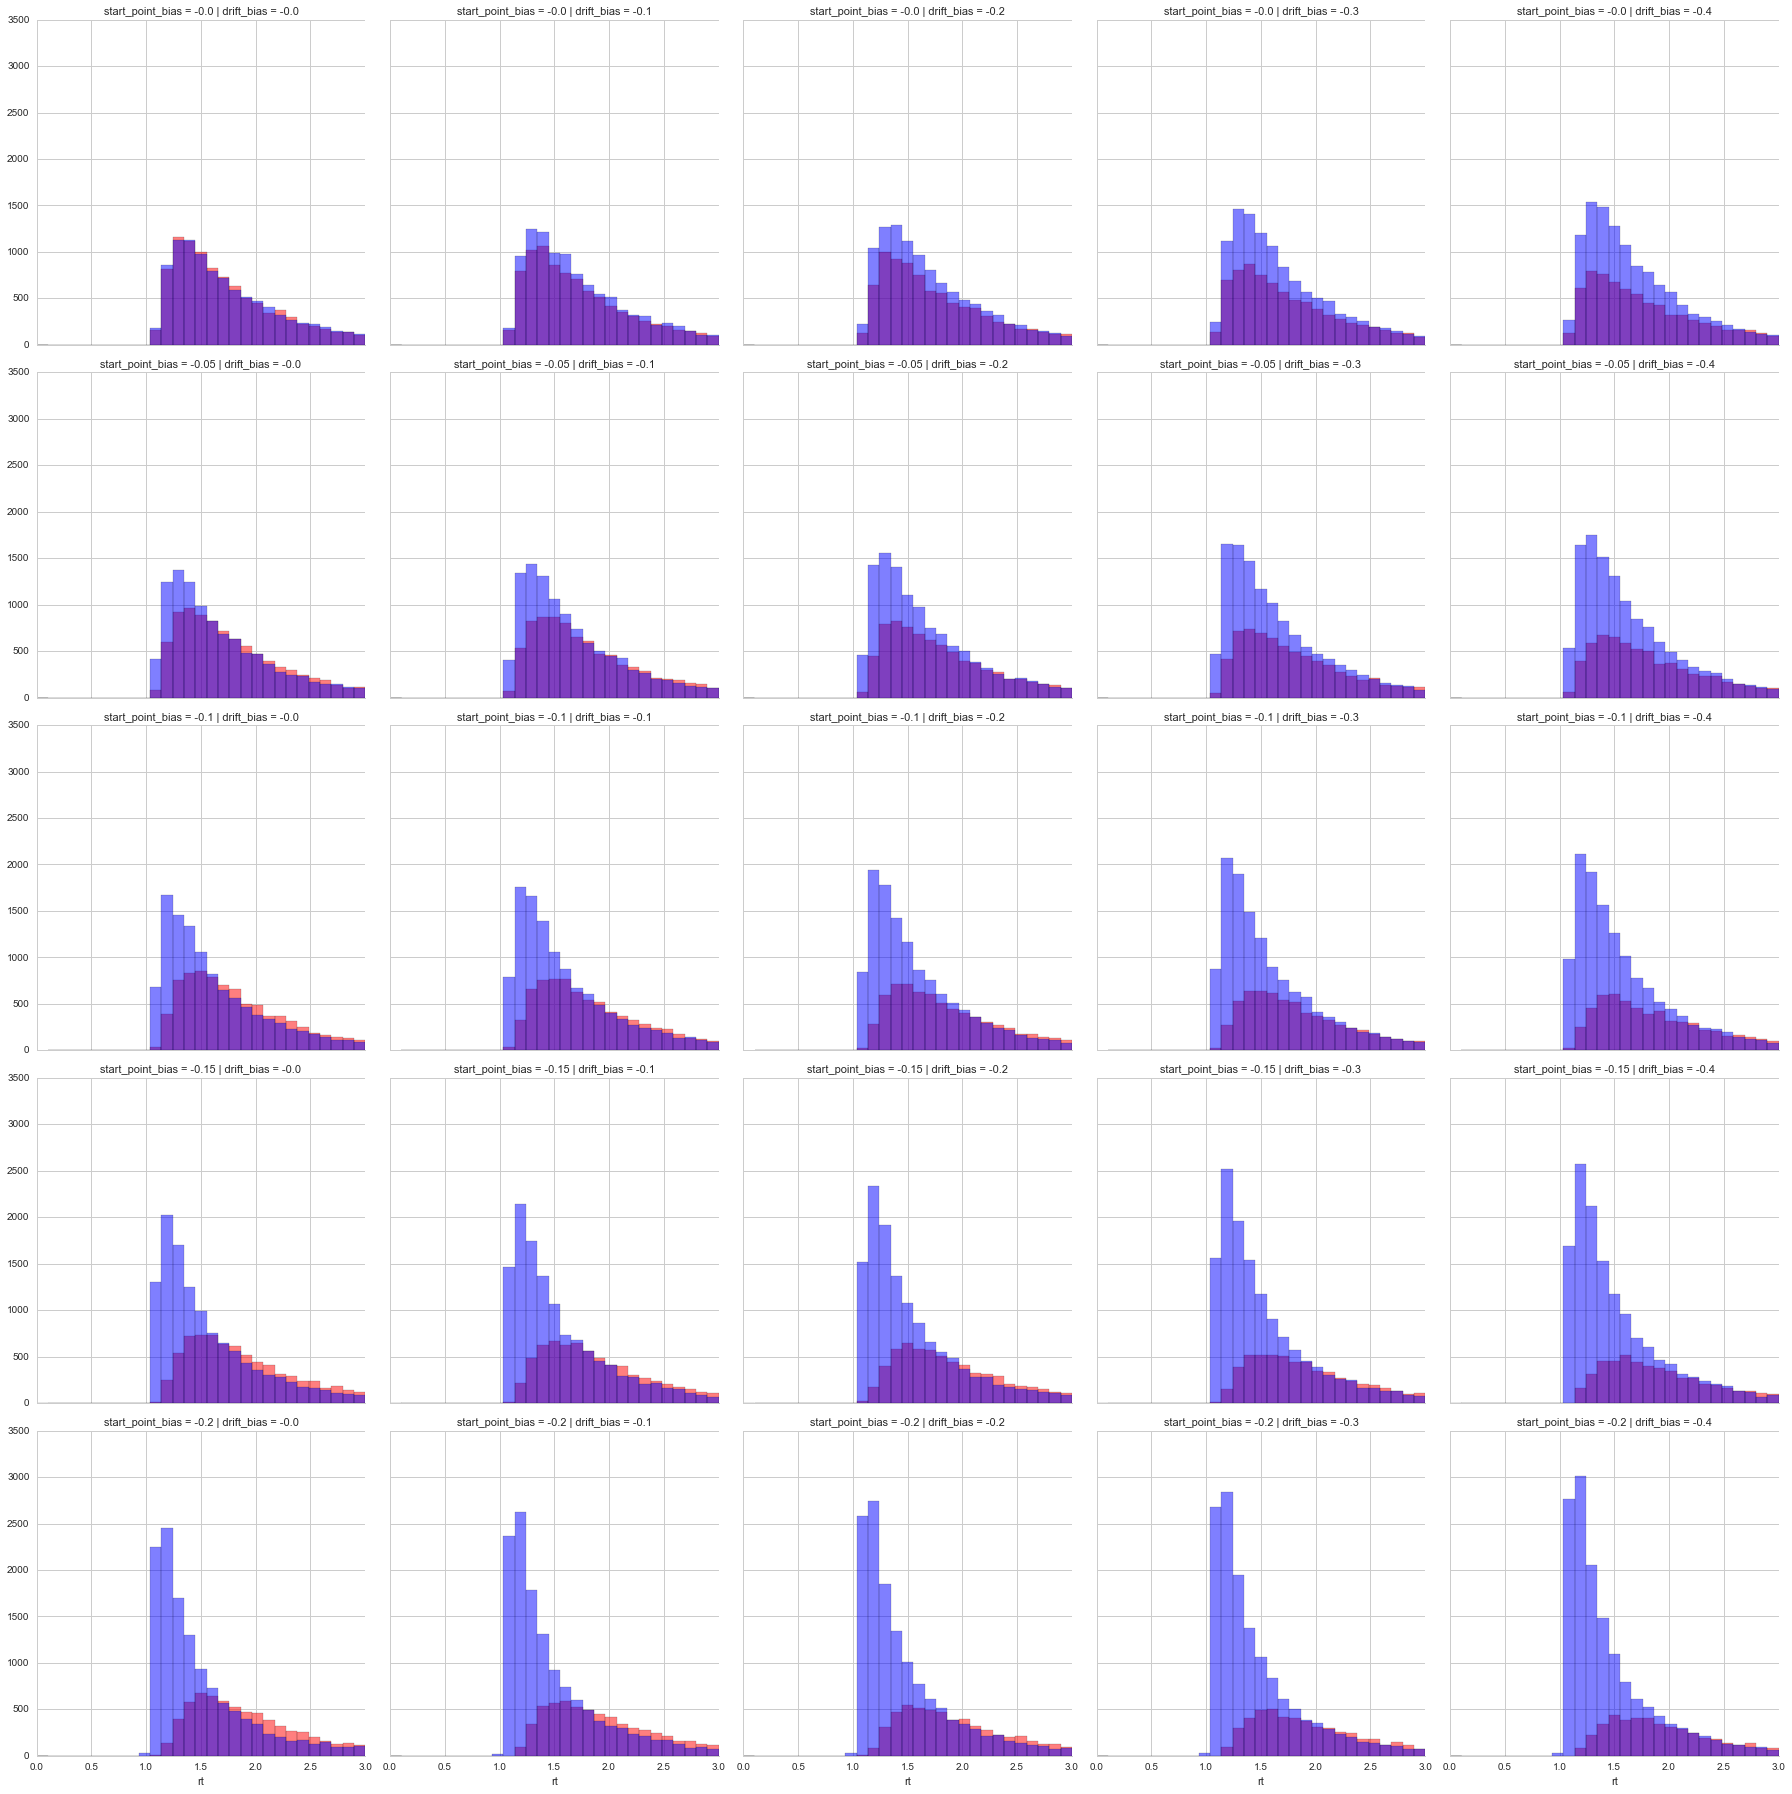

In [153]:
import seaborn as sns
sns.set_palette(['red', 'blue'])
g = sns.FacetGrid(df, col="drift_bias",  row='start_point_bias',
                  hue="bias_response", size=5, 
                  hue_order=['biased_option', 'anti-biased option'],
                  col_order=sorted(df.drift_bias.unique()),                  
                  row_order=sorted(df.start_point_bias.unique()))
sns.set_style('whitegrid')
g.map(sns.distplot, 'rt', bins=np.linspace(0, 3, 30), norm_hist=False, kde=False, hist_kws={'alpha':0.5})
plt.xlim(0, 3)

Now, let's play around a bit, and analytically generate RT distributions based on the defective cumulative distribution:

In [154]:
def sim_Pe(v,a,z,s):
    """
    function for estimating probability of an incorrect response given:
    v = drift rate
    a = boundary separation
    z = starting point
    s = noise
    """
    return (math.e**(-2*v*a/(s**2))-math.e**(-2*v*z/(s**2)))/(math.e**(-2*v*a/(s**2))-1)

def sim_G(t,v,a,z,s,Pe):

    """
    function for estimating probability of an incorrect response given:
    t = current time point (in seconds)
    v = drift rate
    a = boundary separation
    z = starting point
    s = noise
    Pe = probability of incorrect response
    """

    tol = 10e-29 # threshold for terminating sum component of equation
    sum_terms = [0]
    diff_terms= [1,1]
    k = 0
    while True:
        k += 1
        sum_terms.append(sum_terms[k-1] + ((2*k*np.sin(k*np.pi*z/a)*math.e**(-0.5*((((v**2)/(s**2))+((np.pi**2)*(k**2)*(s**2)/(a**2)))*t)))/(((v**2)/(s**2))+((np.pi**2)*(k**2)*(s**2)/(a**2)))))
        diff_terms.append( sum_terms[k] - sum_terms[k-1] )
        if (abs(diff_terms[k]) < (sum_terms[k-1]*tol)) and (abs(diff_terms[k-1]) < (sum_terms[k-2]*tol)):
            break
        
    return Pe-((((np.pi*(s**2))/(a**2))*math.e**(-(v*z/(s**2))))*sum_terms[k])


def lgwt(N,a,b):

    """
    This script is for computing definite integrals using Legendre-Gauss 
    Quadrature. Computes the Legendre-Gauss nodes and weights  on an interval
    [a,b] with truncation order N

    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using sum(f.*w);

    Written by Greg von Winckel - 02/25/2004
    """

    N = N-1
    N1 = N+1
    N2 = N+2

    xu = np.linspace(-1,1,N1)

    # Initial guess
    y = np.cos((2*(np.arange(N+1))+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)

    # Legendre-Gauss Vandermonde Matrix
    L = np.zeros((N1,N2))

    # Derivative of LGVM
    Lp = np.zeros((N1,N2))

    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method
    y0 = 2

    # Iterate until new points are uniformly within epsilon of old points
    while max(abs(y-y0)) > eps:
        L[:,1] = 1
        Lp[:,1] = 0
        L[:,2] = y
        Lp[:,2] = 1
        for k in range(1,N1-1):
            L[:,k+1]=( (2*k-1)*y*L[:,k]-(k-1)*L[:,k-1]) / k
        Lp = (N2)*( L[:,N1-1]-y*L[:,N2-1] ) / (1-y**2)   
        y0 = y
        y = y0 - L[:,N2-1] / Lp

    # Linear map from[-1,1] to [a,b]
    x = (a*(1-y)+b*(1+y))/2      

    # Compute the weights
    w = (b-a)/((1-y**2)*Lp**2)*(N2/N1)^2

    return x, w

In [155]:
# Set parameters
v = 0.06   # drift rate
eta = 0    # drift rate variability
a = 0.2    # boundary separation
z = 0.1    # starting point
sz = 0     # starting point variability
Ter = 0.9  # non-decision time
s = 0.1    # noise

# Set timing parameters
tmax = 4.0 # max RT (in seconds) to estimate first passage times to
dt = 0.01 # time step (in seconds)

# Estimate choice probabilities and defective cumulative probability distributions
Pe = sim_Pe(v,a,z,s)

In [156]:
t = 1.0
print sim_G(t,v,a,z,s,Pe)

0.157312611905


(0, 4.0)

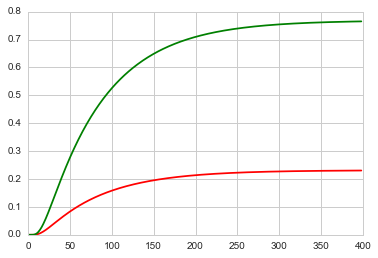

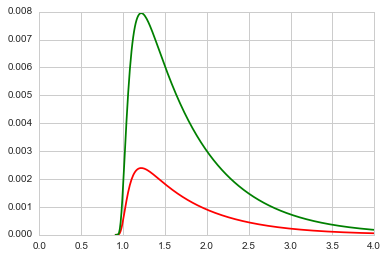

In [157]:
Ge = np.zeros(int(tmax/dt))[:-1]
Gc = np.zeros(int(tmax/dt))[:-1]
for i, t in enumerate(np.arange(dt,tmax,dt)):
    Ge[i] = sim_G(t,v,a,z,s,Pe)
    Gc[i] = sim_G(t,-v,a,a-z,s,1-Pe)

RTe = np.diff(Ge)
RTc = np.diff(Gc)
  
plt.figure()
plt.plot(Ge, color='r')
plt.plot(Gc, color='g')

plt.figure()
plt.plot(np.arange(dt,tmax,dt)[:-1]+Ter, RTe, color='r')
plt.plot(np.arange(dt,tmax,dt)[:-1]+Ter, RTc, color='g')
plt.xlim(0,tmax)

In [158]:
drift_biases = [-0.0, -0.1, -0.2, -0.3, -0.4]
startpoint_biases = [-0.0, -0.05, -0.10, -0.15, -0.20]
parameters = []
conditions = []
for drift_bias, start_point_bias in itertools.product(drift_biases, startpoint_biases):
    # print drift_bias, start_point_bias
    conditions.append('biased.drift.%s.z.%s' % (drift_bias, start_point_bias))
    parameters.append({'v':v+drift_bias, 'a':a, 't':t,'sv':sv, 'z':z+start_point_bias, 'sz': sz, 'st': st})
    conditions.append('anti-biased.drift.%s.z.%s' % (drift_bias, start_point_bias))
    parameters.append({'v':v-drift_bias, 'a':a, 't':t,'sv':sv, 'z':z-start_point_bias, 'sz': sz, 'st': st})

In [159]:
print len(parameters)

50
